# Bayesian Cluster Analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Eager Execution

In [3]:
def evaluate(tensors):
    if tf.executing_eagerly():
        return tf.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.is_tensor(t) else t
             for t in tf.nest.flatten(tensors)])
    return sess.run(tensors)

[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


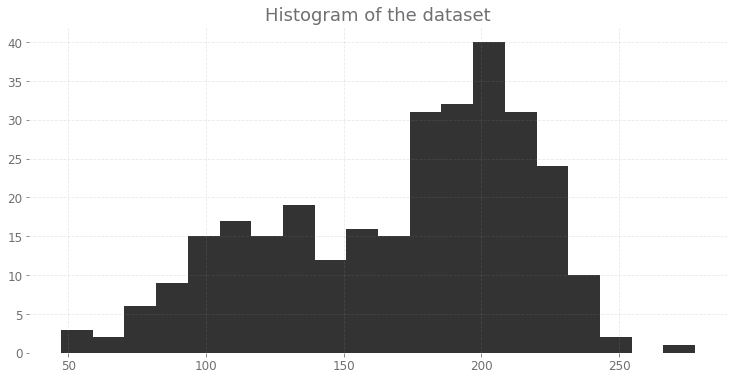

In [4]:
plt.figure(figsize=(12.5, 6))
data_ = np.loadtxt("data/mixture_data.csv", delimiter=",")

plt.hist(data_, bins=20, color="k", histtype="stepfilled", alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None]);
print(data_[:10], "...")

In [5]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [6]:
p1 = tfd.Uniform(name='p', low=0., high=1.).sample()
p2 = 1 - p1
p = tf.stack([p1, p2])
# Categorical Assignment Variable
var_assignment = tfd.Categorical(name='assignment', probs=p)
assignment = var_assignment.sample(10)

[ p_, assignment_ ] = evaluate([p, assignment])
p_, assignment_

(array([0.7556615 , 0.24433851], dtype=float32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int32))

In [7]:
var_sds = tfd.Uniform(name='sds', low=[0., 0.], high=[100., 100.])
var_means = tfd.Normal(name='centers', loc=[120., 190.], scale=[10., 10.])
sds = var_sds.sample()
means = var_means.sample()
var_assignment = tfd.Categorical(probs=tf.stack([0.4, 0.6]))
assignments = var_assignment.sample(10)

var_obs = tfd.MixtureSameFamily(
    var_assignment,
    tfd.Normal(loc=means, scale=sds)
)
obs = var_obs.sample(10)
[ assignments_, obs_, sds_, means_ ] = evaluate([
    assignments, obs, sds, means
])

In [8]:
print('Simulated Data: ', obs_)
print('Assignments: ', assignments_)
print('Center: ', means_)
print('Standard Deviation: ', sds_)

Simulated Data:  [119.71486  185.02808  120.76006  156.2887   121.533356 191.1578
 251.68266  121.250916 308.61072   44.238556]
Assignments:  [0 0 1 1 1 1 1 0 1 1]
Center:  [120.79677 187.31673]
Standard Deviation:  [ 0.55378675 60.08116   ]


In [9]:
def joint_log_prob(data, p1, centers, sds):
    var_p = tfd.Uniform(name='p', low=0., high=1.)
    p2 = 1 - p1
    var_assignment = tfd.Categorical(tf.stack([p1, p2]))
    var_sds = tfd.Uniform(name='sds',low=[0., 0.], high=[100., 100.])
    var_means = tfd.Normal(name='centers', loc=[120., 190.], scale=[10., 10.])
    var_obs = tfd.MixtureSameFamily(
        mixture_distribution=var_assignment,
        components_distribution=tfd.Normal(loc=centers, scale=sds)
    )
    
    return (
        var_p.log_prob(p1)
        + var_p.log_prob(p2)
        + tf.reduce_sum(var_obs.log_prob(data))
        + tf.reduce_sum(var_means.log_prob(centers))
        + tf.reduce_sum(var_sds.log_prob(sds))
    )

## Using `tfp_helper` for Inference

In [10]:
from tfp_helper import *
import arviz as az

In [14]:
trace = infer(joint_log_prob, data_,
              variables=['p', 'means', 'sds'],
              initial_chain_state=[0.5, [120., 190.], [10., 10.]],
              nsteps=50000, burn_in_ratio=0.3
             )

100%|██████████| 10/10 [00:52<00:00,  5.26s/it]


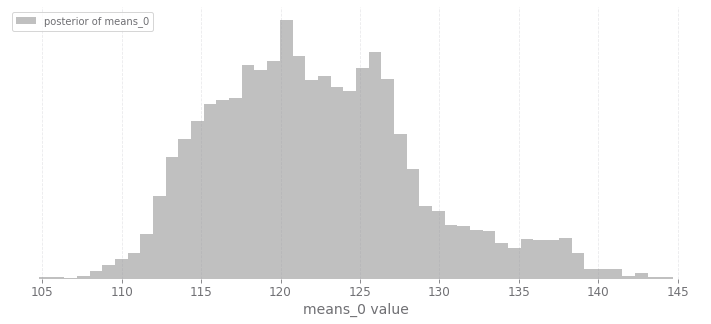

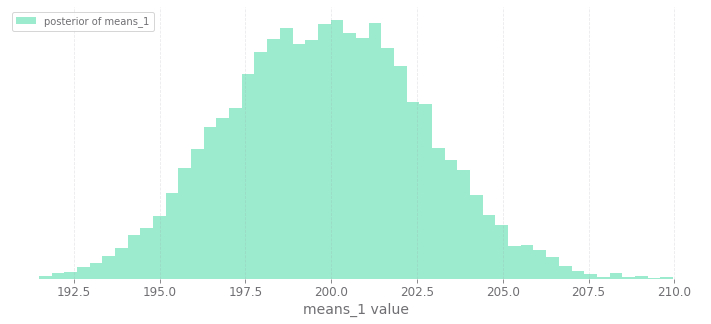

In [15]:
plot_posterior_hist(trace, 'means')

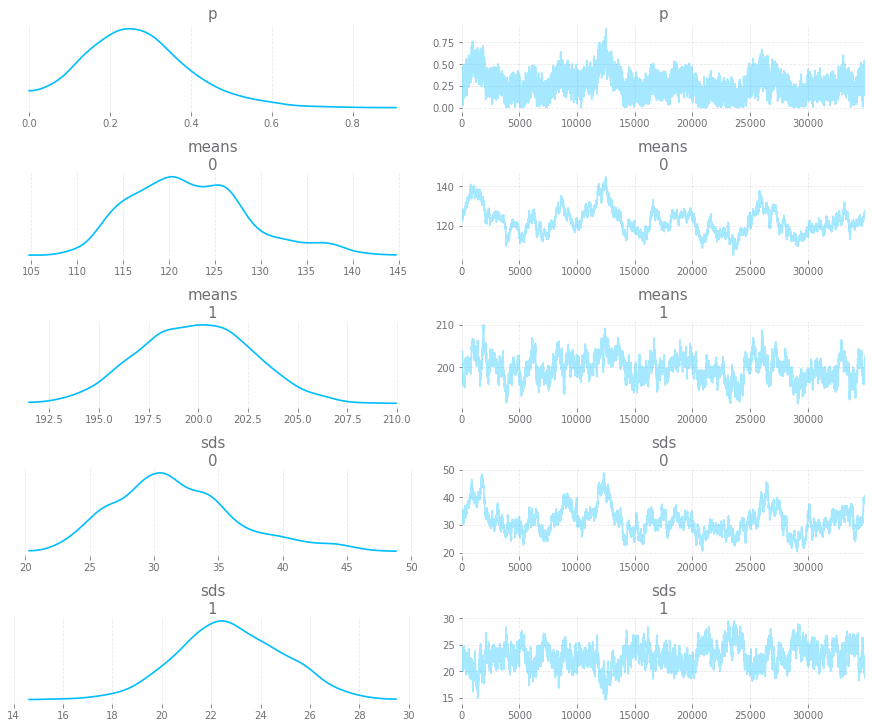

In [16]:
az.plot_trace(trace);

## Cluster Prediction

In [17]:
from tfp_helper import *

In [22]:
posterior_data = az_to_numpy(trace, flatten=False)

In [27]:
p_trace = posterior_data[0][0]
std_trace = posterior_data[-1][0]
center_trace = posterior_data[1][0]

In [53]:
x = 175
score_cluster_1 = (1 - p_trace[25000:]) * tfd.Normal(loc=center_trace[25000:, 1], scale=std_trace[25000:, 1]).log_prob(x)
score_cluster_0 = p_trace[25000:] * tfd.Normal(loc=center_trace[25000:, 0], scale=std_trace[25000:, 0]).log_prob(x)

In [54]:
p_x_0 = evaluate(score_cluster_1 > score_cluster_0).mean()
p_x_1 = evaluate(score_cluster_1 < score_cluster_0).mean()

print('Probability of x={} belonging to Cluster_0 : [{}]'.format(x, p_x))
print('Probability of x={} belonging to Cluster_1 : [{}]'.format(x, p_x_1))

Probability of x=175 belonging to Cluster_0 : [0.0301]
Probability of x=175 belonging to Cluster_1 : [0.9699]
